In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import regex as re
import gensim
from gensim.models import Word2Vec
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
DATASET_ENCODING = "ISO-8859-1"
df=pd.read_csv('IMDB-movie-reviews.csv',delimiter=';',encoding=DATASET_ENCODING)

# Data exploration

In [106]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [107]:
df

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

In [98]:
pd.reset_option('display.max_colwidth')

In [102]:
df[df['sentiment']=='negative']['review']

3     Basically there's a family where a little boy ...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
12    So im not a big fan of Boll's work but then ag...
13    The cast played Shakespeare.<br /><br />Shakes...
15    Kind of drawn in by the erotic scenes, only to...
17    This movie made it into one of my top 10 most ...
19    An awful film! It must have been up against so...
21    I had the terrible misfortune of having to vie...
23    First of all, let's get a few things straight ...
24    This was the worst movie I saw at WorldFest an...
27    This film tried to be too many things all at o...
28    This movie was so frustrating. Everything seem...
32    My first exposure to the Templarios & not a go...
34    I watched this film not really expecting much,...
35    I bought this film at Blockbuster for $3.0

In [100]:
df[df['sentiment']=='positive']['review']

0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
4     Petter Mattei's "Love in the Time of Money" is...
5     Probably my all-time favorite movie, a story o...
6     I sure would like to see a resurrection of a u...
9     If you like original gut wrenching laughter yo...
14    This a fantastic movie of three prisoners who ...
16    Some films just simply should not be remade. T...
18    I remember this film,it was the first film i h...
20    After the success of Die Hard and it's sequels...
22    What an absolutely stunning movie, if you have...
25    The Karen Carpenter Story shows a little more ...
26    "The Cell" is an exotic masterpiece, a dizzyin...
29    'War movie' is a Hollywood genre that has been...
30    Taut and organically gripping, Edward Dmytryk'...
31    "Ardh Satya" is one of the finest film ever ma...
33    One of the most significant quotes from th

In [112]:
from wordcloud import WordCloud

def get_wordcloud(data):
  # Get the positive and negative reviews
  positive_reviews = data[data['sentiment'] == 'positive']['review']
  negative_reviews = data[data['sentiment'] == 'negative']['review']

  # Create a wordcloud for positive reviews
  positive_wordcloud = WordCloud(width=1600, height=1200, background_color='white').generate(' '.join(positive_reviews))

  # Create a wordcloud for negative reviews
  negative_wordcloud = WordCloud(width=1600, height=1200, background_color='white').generate(' '.join(negative_reviews))

  # Plot the wordclouds
  plt.figure(figsize=(20, 20))
  plt.subplot(1, 2, 1)
  plt.imshow(positive_wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Positive Reviews Wordcloud')

  plt.subplot(1, 2, 2)
  plt.imshow(negative_wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Negative Reviews Wordcloud')

  plt.show()

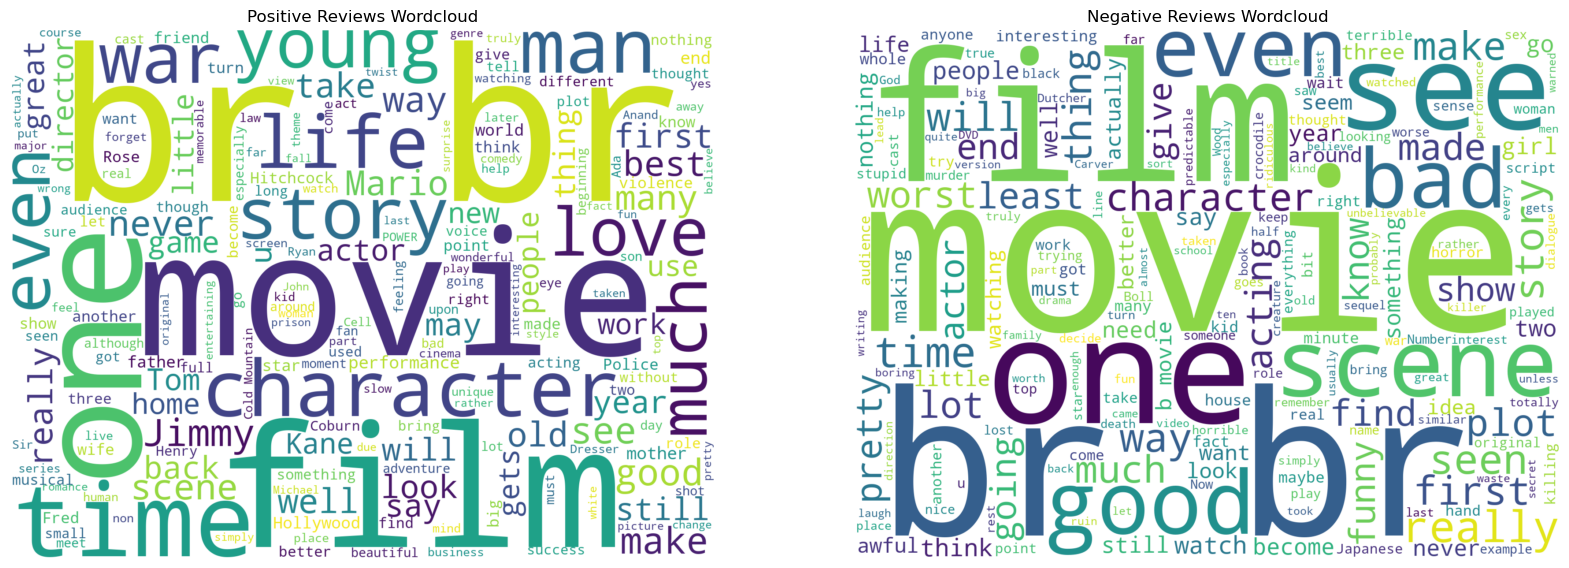

In [113]:
get_wordcloud(df)

In [114]:
df.duplicated().sum()

0

In [115]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

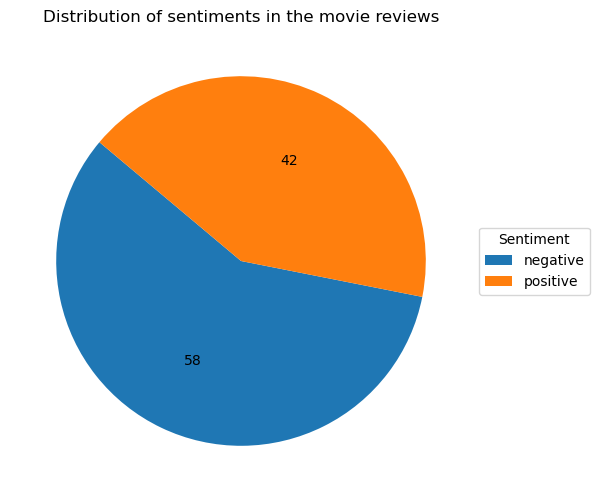

In [116]:
# Calculate the count of each class
sentiment_count = df['sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(6, 6))
pie_wedges = plt.pie(sentiment_count, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sentiment_count.sum() / 100))

# Adding a legend
plt.legend(pie_wedges[0], ['negative', 'positive'], title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribution of sentiments in the movie reviews')
plt.show()


In [136]:
def preprocess_text(text):
    text = text.str.replace(r'<.*?>', '', regex=True) # Removing everything that is between <>
    text = text.str.replace(f"[{string.punctuation}]", "", regex=True)
    text = text.str.lower()
    text = text.str.split()
    #text = text.apply(lambda x: [word for word in x if word not in stop_words])
    #text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return text.str.join(" ")

In [137]:
%%time
df['review']=preprocess_text(df['review'])

CPU times: total: 0 ns
Wall time: 4.57 ms


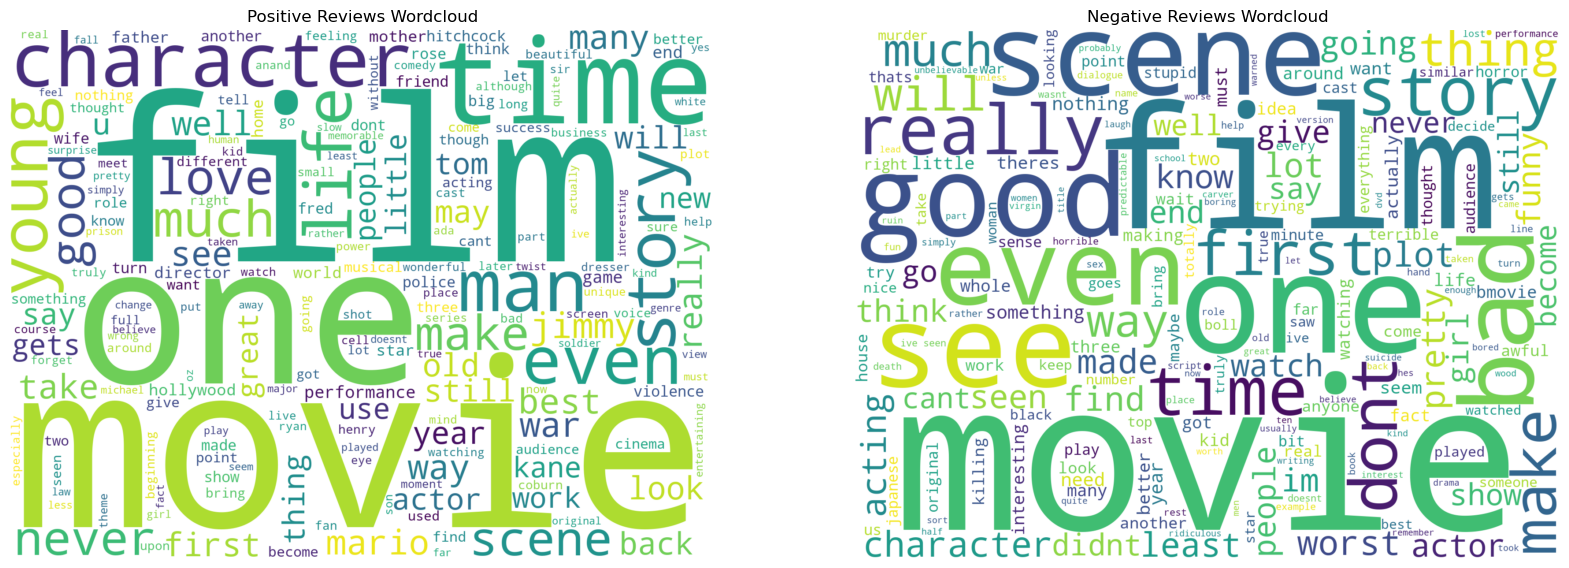

In [138]:
get_wordcloud(df)

# Word2vec

## Text embedding

In [124]:
def simple_tokenizer(text):
    tokens = re.split(r'\s+', text)
    return tokens

In [10]:
def handle_negations(tokens):
    negations = {"not", "no", "never", "n't"}
    new_tokens = []
    negation_mode = False
    for token in tokens:
        if token in negations:
            negation_mode = True
            new_tokens.append(token)
        elif negation_mode:
            new_tokens.append(f"not_{token}")
            negation_mode = False
        else:
            new_tokens.append(token)
    return new_tokens

def advanced_tokenizer(text):
    tokens = re.split(r'\s+', text)
    tokens = handle_negations(tokens)
    return tokens

In [11]:
df['tokens']=df['review'].apply(advanced_tokenizer)

In [12]:
tokenized_text=df['tokens'].tolist()

In [13]:
# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

In [14]:
def document_vector(tokens):
    # Filter tokens that are present in the Word2Vec model's vocabulary
    valid_tokens = [token for token in tokens if token in word2vec_model.wv]
    # Compute the mean of the vectors for the valid tokens
    if valid_tokens:
        return np.mean(word2vec_model.wv[valid_tokens], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

In [15]:
# Apply the document vector function to each document
df['vector'] = df['tokens'].apply(document_vector)

# Convert list of vectors to a numpy array
X = np.array(df['vector'].tolist())

In [16]:
X

array([[-0.08807455,  0.14811788, -0.01089816, ..., -0.15449266,
        -0.0026898 ,  0.02748544],
       [-0.09557059,  0.1613374 , -0.01140364, ..., -0.16968186,
        -0.00340018,  0.03087947],
       [-0.10084127,  0.1686    , -0.01151857, ..., -0.17510907,
        -0.00426444,  0.03124476],
       ...,
       [-0.08162149,  0.13793528, -0.01022869, ..., -0.14206687,
        -0.00292859,  0.02538594],
       [-0.09569769,  0.16238329, -0.01165294, ..., -0.1689932 ,
        -0.00341594,  0.03034728],
       [-0.09757952,  0.1636753 , -0.01133375, ..., -0.17167476,
        -0.00337773,  0.03088535]], dtype=float32)

## Model training

In [125]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, roc_auc_score

In [126]:
# Assuming X and y are already defined
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
   # "SVM": SVC(probability=True),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
   # "LightGBM": LGBMClassifier()
}



In [128]:
# Perform cross-validation and store results
def perform_cross_validation(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    return np.mean(scores)



def evaluate_models_cv(models,X,y):
  scoresCV_list=[]
  for model_name, model in models.items():
    score=perform_cross_validation(model, X, y)
    scoresCV_list.append(score)
  # Plotting the cross-validation results
  plt.figure(figsize=(10, 6))
  bars = plt.bar(models.keys(), scoresCV_list, color='skyblue')
  plt.xlabel('Models')
  plt.ylabel('Cross-Validation Accuracy')
  plt.title('Cross-Validation Accuracy of Different Models')
  plt.ylim([min(scoresCV_list) - 0.05, max(scoresCV_list) + 0.05])  # Set y-axis limits to give some space
  # Add text on top of the bars
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
  plt.show()



def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
  results = {}
  for model_name, model in models.items():
      # Perform 5-fold cross-validation
      cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
      # Train the model on the full training data and evaluate on the test set
      model.fit(X_train, y_train)
      predictions = model.predict(X_test)
      pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

      accuracy = accuracy_score(y_test, predictions)
      report = classification_report(y_test, predictions, output_dict=True)
      conf_matrix = confusion_matrix(y_test, predictions)

      results[model_name] = {
          "model": model,
          "cross_val_accuracy": np.mean(cv_scores),
          "accuracy": accuracy,
          "report": report,
          "conf_matrix": conf_matrix,
          "pred_prob": pred_prob
      }

      print(f"{model_name} Results:")
      print(f"Cross-Validation Accuracy: {np.mean(cv_scores)}")
      print(f"Test Accuracy: {accuracy}")
      print("Classification Report:")
      print(classification_report(y_test, predictions))
      print("Confusion Matrix:")
      print(confusion_matrix(y_test, predictions))
      print("\n")




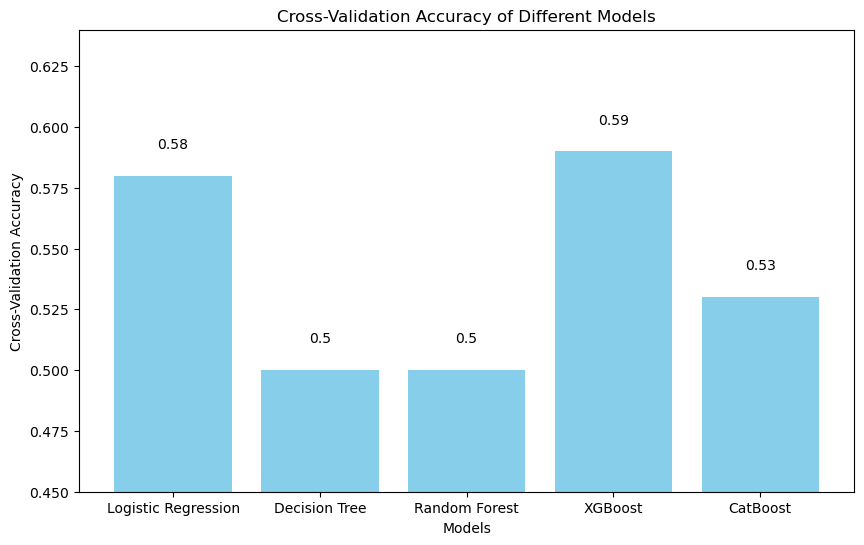

In [58]:
evaluate_models_cv(models,X,y)

## FastText

In [59]:
from gensim.models import FastText

In [60]:
fasttext_model=FastText(sentences=tokenized_text,vector_size=100,window=5,min_count=1,workers=4)

In [61]:
def document_vector(tokens):
    # Filter tokens that are present in the FastText model's vocabulary
    valid_tokens = [token for token in tokens if token in fasttext_model.wv]
    # Compute the mean of the vectors for the valid tokens
    if valid_tokens:
        return np.mean(fasttext_model.wv[valid_tokens], axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)

In [62]:
# Apply the document vector function to each document
df['vector'] = df['tokens'].apply(document_vector)

# Convert list of vectors to a numpy array
X_ft = np.array(df['vector'].tolist())

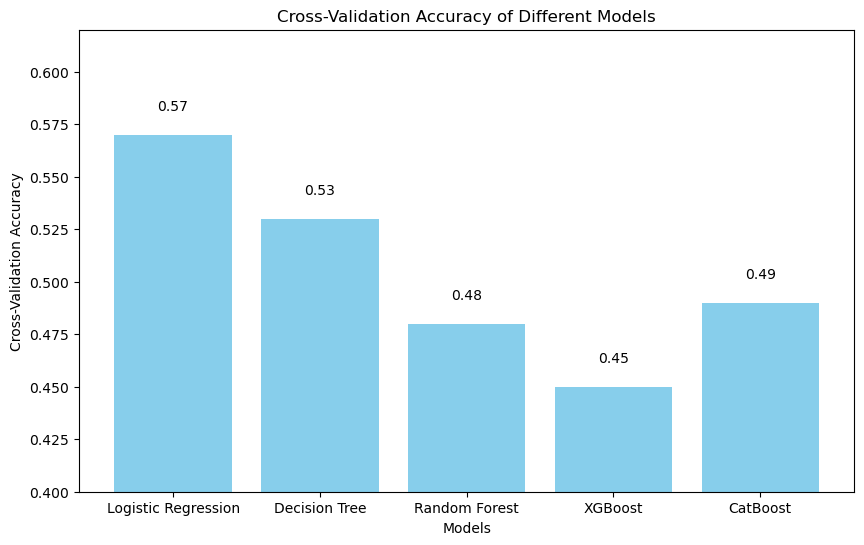

In [63]:
evaluate_models_cv(models,X_ft,y)

# Glove

In [37]:
import numpy as np

In [38]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


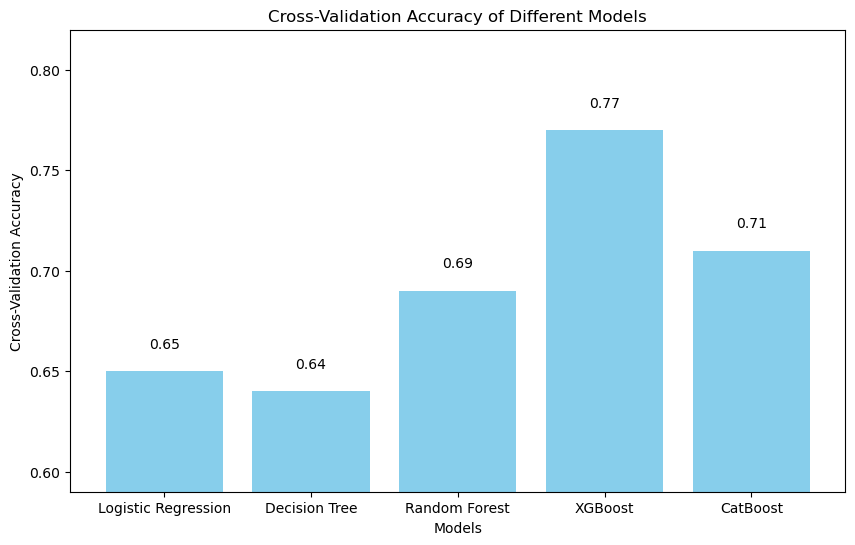

In [85]:
embeddings_index = {}

with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        vec = np.fromstring(vec, sep=' ', dtype=np.float32)
        embeddings_index[word] = vec

def document_vector(tokens):
    # Filter tokens that are present in the GloVe model's vocabulary
    valid_tokens = [token for token in tokens if token in embeddings_index]
    # Compute the mean of the vectors for the valid tokens
    if valid_tokens:
        return np.mean([embeddings_index[token] for token in valid_tokens], axis=0)
    else:
        return np.zeros(len(embeddings_index['the']))
# Apply the document vector function to each document
df['vector'] = df['tokens'].apply(document_vector)

# Convert list of vectors to a numpy array
X_glove = np.array(df['vector'].tolist())


# Evaluate models on Glove Embeddings
evaluate_models_cv(models, X_glove, y)


# Vectorizers

##Tf-IDf

In [64]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [65]:
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])

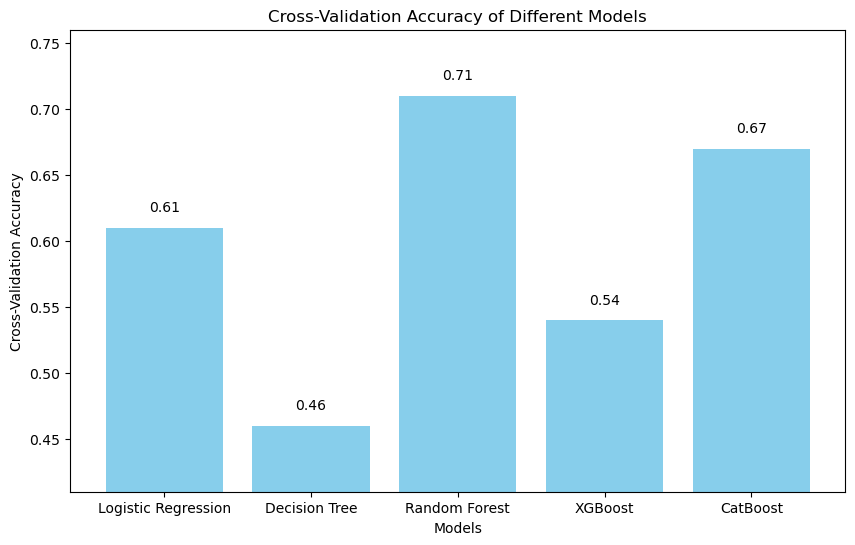

In [66]:
evaluate_models_cv(models, X_tfidf, y)

## hashing vectorizers

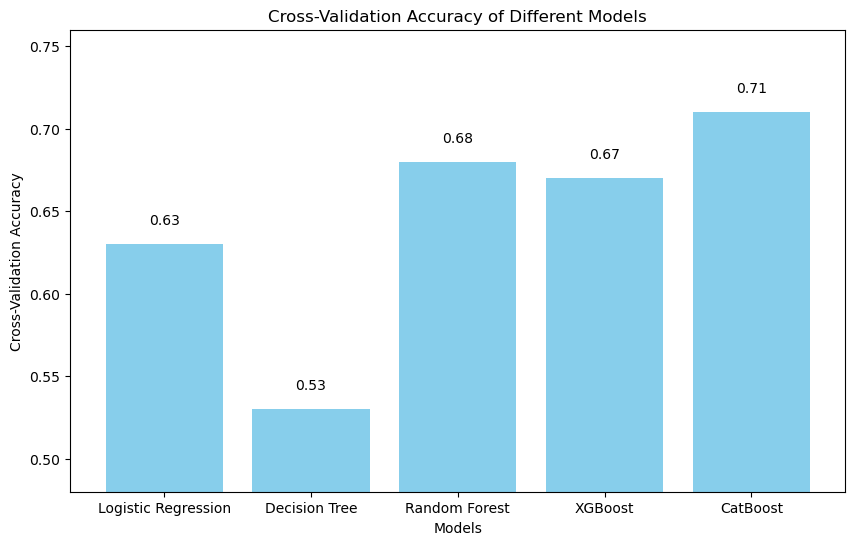

In [67]:
hash_vectorizer=HashingVectorizer(n_features=1000)
X_hash = hash_vectorizer.fit_transform(df['review'])
evaluate_models_cv(models, X_hash, y)

# BERT

In [68]:
import transformers
from transformers import BertTokenizer, BertModel
import torch

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [69]:
def bert_tokenizer(text):
    # Encode the text using the BERT tokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    return inputs

def get_bert_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Move outputs to the CPU before converting to numpy

In [70]:
# Create BERT embeddings for each text
df['vector_bert'] = df['review'].apply(lambda text: get_bert_embeddings(text, model, tokenizer))
# Convert list of vectors to a numpy array
X_Bert = np.array(df['vector_bert'].tolist())

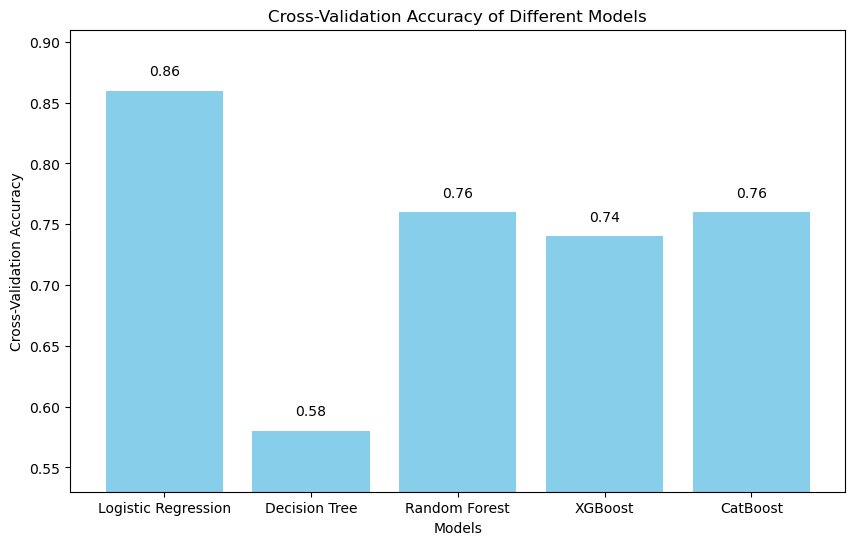

In [72]:
evaluate_models_cv(models, X_Bert, y)

# RoBERTa

In [71]:
from transformers import RobertaConfig, RobertaModel
from transformers import RobertaTokenizer

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


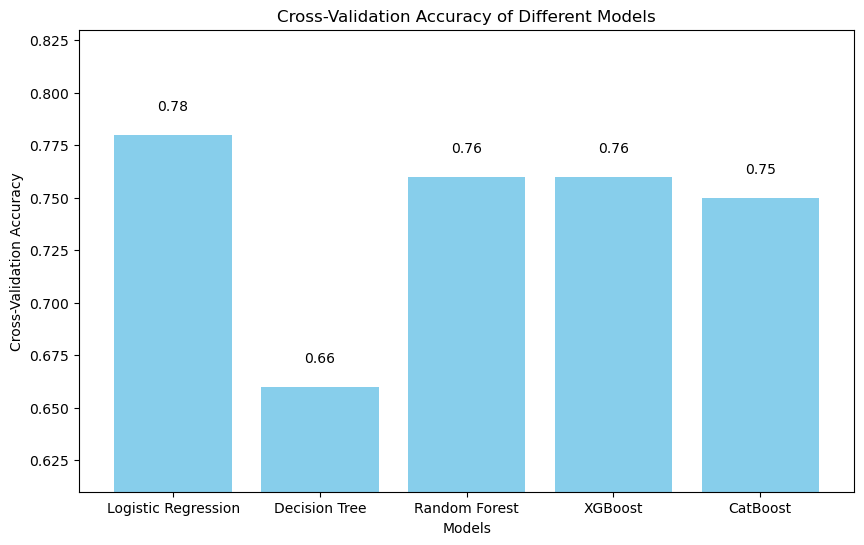

In [73]:
# prompt: now how about roberta

import numpy as np
# Load the pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def roberta_tokenizer(text):
    # Encode the text using the RoBERTa tokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    return inputs

def get_roberta_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Move outputs to the CPU before converting to numpy


# Create RoBERTa embeddings for each text
df['vector_roberta'] = df['review'].apply(lambda text: get_roberta_embeddings(text, model, tokenizer))
# Convert list of vectors to a numpy array
X_Roberta = np.array(df['vector_roberta'].tolist())
evaluate_models_cv(models, X_Roberta, y)


# GPT

In [139]:
from transformers import OpenAIGPTModel, OpenAIGPTTokenizer

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


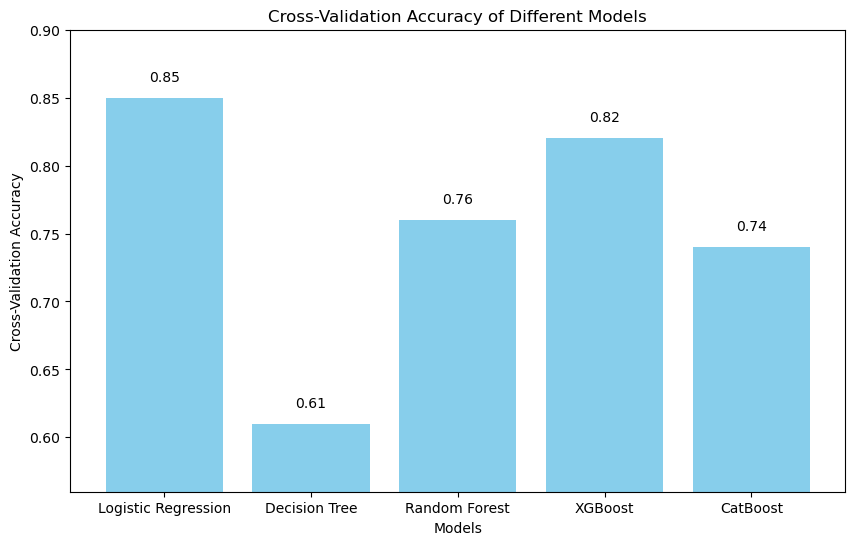

In [140]:
import numpy as np
from transformers import AutoTokenizer, OpenAIGPTModel

# Load the pre-trained OpenAI GPT model and tokenizer
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-community/openai-gpt")
model = OpenAIGPTModel.from_pretrained("openai-community/openai-gpt")

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def gpt_tokenizer(text):
    # Encode the text using the OpenAI GPT tokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=512)
    return inputs

def get_gpt_embeddings(text, model, tokenizer):
    inputs=gpt_tokenizer(text)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Move outputs to the CPU before converting to numpy


# Create OpenAI GPT embeddings for each text
df['vector_gpt'] = df['review'].apply(lambda text: get_gpt_embeddings(text, model, tokenizer))
# Convert list of vectors to a numpy array
X_GPT = np.array(df['vector_gpt'].tolist())
evaluate_models_cv(models, X_GPT, y)


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


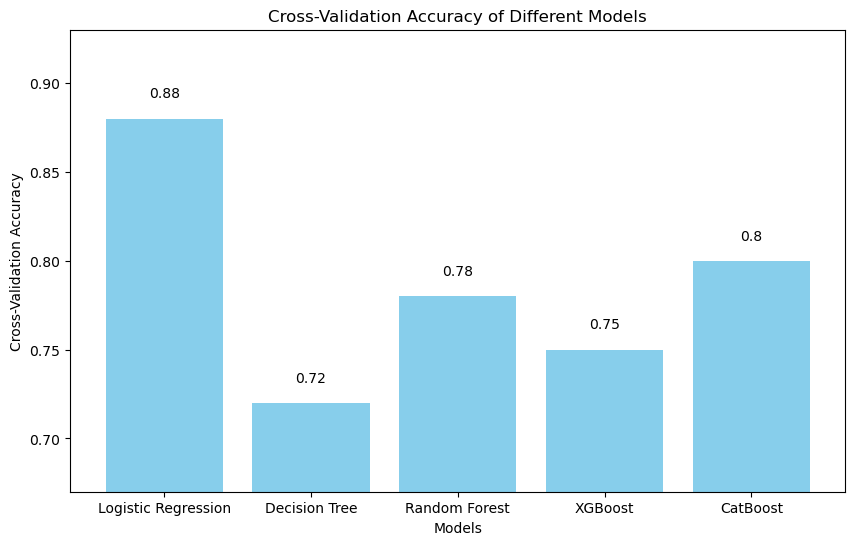

In [76]:
import numpy as np
from transformers import AutoTokenizer, OpenAIGPTModel

# Load the pre-trained OpenAI GPT model and tokenizer
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-community/openai-gpt")
model = OpenAIGPTModel.from_pretrained("openai-community/openai-gpt")

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def gpt_tokenizer(text):
    # Encode the text using the OpenAI GPT tokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=512)
    return inputs

def get_gpt_embeddings(text, model, tokenizer):
    inputs=gpt_tokenizer(text)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Move outputs to the CPU before converting to numpy


# Create OpenAI GPT embeddings for each text
df['vector_gpt'] = df['review'].apply(lambda text: get_gpt_embeddings(text, model, tokenizer))
# Convert list of vectors to a numpy array
X_GPT = np.array(df['vector_gpt'].tolist())
evaluate_models_cv(models, X_GPT, y)


# Fine-tuning

## GPT + LogisticRegression

It seems like the best embedding is the GPT embedding with the LogisticRegression() model for this dataset, let's use GridSearch to make it better

In [146]:
from sklearn.model_selection import GridSearchCV

In [147]:
lr = LogisticRegression()

In [148]:
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'none'],  # Types of penalties
    'solver': ['newton-cg', 'liblinear', 'saga'],  # Solvers
    'max_iter': [200, 300]  # Maximum number of iterations taken for the solvers to converge  
}

In [149]:
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy',verbose=1)

In [150]:
# Perform the grid search on the resampled training data
grid_search.fit(X_GPT, y)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'C': 4.281332398719396, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy Score: 0.8899999999999999


## TF-IDF + CATBOOST

In [ ]:
param_grid_cb = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 10],
    'l2_leaf_reg': [1, 5, 7],
    'bootstrap_type': ['Bayesian', 'Bernoulli'],

}

In [ ]:
cb_model = CatBoostClassifier(verbose=10)
grid_search_cb = GridSearchCV(cb_model, param_grid_cb, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

In [ ]:
grid_search_cb.fit(X_tfidf, y)

# Print the best parameters and best score
print("Best Parameters:", grid_search_cb.best_params_)
print("Best Accuracy Score:", grid_search_cb.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
0:	learn: 0.6717839	total: 22.6ms	remaining: 4.5s
10:	learn: 0.4777692	total: 148ms	remaining: 2.55s
20:	learn: 0.3759772	total: 276ms	remaining: 2.35s
30:	learn: 0.2981409	total: 401ms	remaining: 2.19s
40:	learn: 0.2389862	total: 525ms	remaining: 2.04s
50:	learn: 0.1913066	total: 646ms	remaining: 1.89s
60:	learn: 0.1490260	total: 783ms	remaining: 1.78s
70:	learn: 0.1108368	total: 903ms	remaining: 1.64s
80:	learn: 0.0819061	total: 1.03s	remaining: 1.51s
90:	learn: 0.0633000	total: 1.15s	remaining: 1.38s
100:	learn: 0.0493231	total: 1.27s	remaining: 1.25s
110:	learn: 0.0400139	total: 1.4s	remaining: 1.12s
120:	learn: 0.0330354	total: 1.52s	remaining: 994ms
130:	learn: 0.0278489	total: 1.64s	remaining: 866ms
140:	learn: 0.0243885	total: 1.77s	remaining: 740ms
150:	learn: 0.0213496	total: 1.9s	remaining: 618ms
160:	learn: 0.0184802	total: 2.03s	remaining: 491ms
170:	learn: 0.0166486	total: 2.15s	remaining: 365ms
180:	learn: 0.

# Saving the best model

In [82]:
import joblib

In [83]:
best_rf = grid_search.best_estimator_

In [84]:
joblib.dump(best_rf, "lr_GPT_sentA_model.pkl")

['lr_GPT_sentA_model.pkl']

In [90]:
!pip freeze > modules.txt